### 0. Some libraries

In [1]:
from time import time
start = time()

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tracemalloc
tracemalloc.start()

### 1. Data and Data Preprocessing with Encoding

In [3]:
def sgn(x):
    if x < 0:
        return 0
    else:
        return 1
    
def budget_encoding(feature, mydf):
    dict = {}
    for encounter in mydf[feature].unique():
        dict[encounter] = sum(mydf[mydf[feature] == encounter]["Budget(INR)"])/sum(mydf[feature] == encounter)
    
    return dict

In [4]:
movies = pd.read_csv("Data for repository.csv")
movies.rename({'Revenue(INR)': 'Budget(INR)', 'Budget(INR)': 'Revenue(INR)'}, axis=1, inplace=True)

movies["label"] = movies["Revenue(INR)"] - movies["Budget(INR)"]
movies["label"] = movies["label"].map(sgn)

In [5]:
df = movies.copy()

In [6]:
## Binary Encoding

for col in ['Whether Remake', 'Whether Franchise', 'New Actor', 'New Director', 'New Music Director']:
    df[col] = df[col].map({'No':0, 'Yes':1})

df['Release Period'] = df['Release Period'].map({'Holiday':1, 'Normal':0})

<AxesSubplot:xlabel='Whether Franchise', ylabel='Probability'>

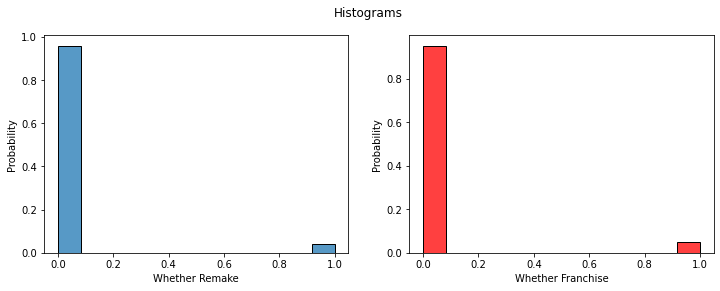

In [7]:
## Highly skewed features

fig, axes = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle('Histograms')
sns.histplot(ax=axes[0], data=df, x='Whether Remake', stat='probability')
sns.histplot(ax=axes[1], data=df, x='Whether Franchise',stat='probability', color='red')

In [8]:
## Log transforming and budget encoding

for col in ['Number of Screens', 'Budget(INR)', 'Revenue(INR)']:
    df[col] = np.log(df[col])

for col in ['Genre', 'Lead Star', 'Director', 'Music Director']:
    df[col] = df[col].map(budget_encoding(col, df))

In [9]:
## Category encoding using Sturges' formula

X = df.drop(['Movie Name', 'Whether Remake', 'Whether Franchise', 'Revenue(INR)', 'label'], axis='columns')

## Category encoding based on Sturge's law 
## Grouping data into bins if variety > 16

for col in ['Genre', 'Lead Star', 'Director', 'Music Director', 'Number of Screens', 'Budget(INR)']:
    uniq = len(X[col].unique())

    sturges = 1 + round(np.log2(len(X)))

    if uniq < sturges:
        X[col] = pd.cut(X[col], bins=uniq, labels=[j for j in range(uniq)])
    else:
        X[col] = pd.cut(X[col], bins=sturges, labels=[j for j in range(sturges)])

y = df['label']

### 2. Random Forest Classifier

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, average_precision_score

In [11]:
## Stratified test-train split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=88)

In [12]:
## Parameter grid for grid search

param_grid = {
    #'criterion': ['gini', 'entropy'],
    'n_estimators': [j for j in range(250,501,50)],
    'max_depth': [j for j in range(2,13,2)],
    'min_samples_split': [j for j in range(2,11,2)]
}

In [13]:
grid = GridSearchCV(RandomForestClassifier(), 
                    param_grid, verbose=1, n_jobs=-1, 
                    refit=True, scoring='average_precision',
                    cv = 5)

In [14]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12],
                         'min_samples_split': [2, 4, 6, 8, 10],
                         'n_estimators': [250, 300, 350, 400, 450, 500]},
             scoring='average_precision', verbose=1)

In [15]:
print('Best avg precision:{:.3f}'.format(grid.best_score_))
print('Best parameters:', grid.best_params_)

print('Test avg precision: {:.3f}'.format(grid.score(X_test, y_test)))

Best avg precision:0.732
Best parameters: {'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 400}
Test avg precision: 0.765


In [27]:
## final tree based on grid search

finaltree = RandomForestClassifier(max_depth=4, min_samples_split=2, n_estimators=400)
finaltree.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, n_estimators=400)

### 3. AdaBoost Classifier

In [17]:
from sklearn.ensemble import AdaBoostClassifier

In [18]:
param_grid = {
    'n_estimators': [j for j in range(550,701,50)],
    'learning_rate': [j/100 for j in range(1,21)]
}

In [19]:
grid = GridSearchCV(AdaBoostClassifier(), 
                    param_grid, verbose=1, n_jobs=-1, 
                    refit=True, scoring='average_precision',
                    cv = 5)

In [20]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06,
                                           0.07, 0.08, 0.09, 0.1, 0.11, 0.12,
                                           0.13, 0.14, 0.15, 0.16, 0.17, 0.18,
                                           0.19, 0.2],
                         'n_estimators': [550, 600, 650, 700]},
             scoring='average_precision', verbose=1)

In [21]:
print('Best avg precision:{:.3f}'.format(grid.best_score_))
print('Best parameters:', grid.best_params_)

print('Test avg precision: {:.3f}'.format(grid.score(X_test, y_test)))

Best avg precision:0.729
Best parameters: {'learning_rate': 0.1, 'n_estimators': 600}
Test avg precision: 0.738


In [22]:
boost = AdaBoostClassifier(learning_rate=0.1, n_estimators=600)
boost.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.1, n_estimators=600)

### 4. Results

In [28]:
print('AdaBoostClassifier: {:.3f}'.format(average_precision_score(y_test, boost.predict(X_test))))
print('RandomForestClassifier: {:.3f}'.format(average_precision_score(y_test, finaltree.predict(X_test))))


AdaBoostClassifier: 0.511
RandomForestClassifier: 0.539


In [29]:
## Classification report for best estimator

print('RandomForestClassifier')
print(classification_report(y_test, finaltree.predict(X_test)))

RandomForestClassifier
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       307
           1       0.67      0.66      0.67       118

    accuracy                           0.82       425
   macro avg       0.77      0.77      0.77       425
weighted avg       0.82      0.82      0.82       425



### 6. Space and Time Complexity

In [25]:
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print("Memory used")
print("Current [MB]", round(current/(1024*1024), 2))
print("Peak [MB]", round(peak//(1024*1024), 2))

Memory used
Current [MB] 14.73
Peak [MB] 15


In [26]:
print("Time elapsed [s] ", round(time() - start, 2))

Time elapsed [s]  180.79
